# Step 1 : Importing Essential Libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
# TensorFlow/Keras imports
from tensorflow.keras.utils import to_categorical  # Updated import for one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scikit-learn imports
from sklearn.model_selection import train_test_split


In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


# Step 2 : Importing Data and Creating a Dataframe

In [15]:
import os
import pandas as pd

# Define directories
train_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Prepare lists to store data
train_data = []
test_data = []

# Collect train data
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

# Collect test data
for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Combine train and test DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)

# Clean up unnecessary variables
del test_df, train_df

df

,image_path,label
0,Skin cancer ISIC The International Skin Imagin...,0
1,Skin cancer ISIC The International Skin Imagin...,0
2,Skin cancer ISIC The International Skin Imagin...,0
3,Skin cancer ISIC The International Skin Imagin...,0
4,Skin cancer ISIC The International Skin Imagin...,0
...,...,...
2352,Skin cancer ISIC The International Skin Imagin...,7
2353,Skin cancer ISIC The International Skin Imagin...,7
2354,Skin cancer ISIC The International Skin Imagin...,8
2355,Skin cancer ISIC The International Skin Imagin...,8


In [16]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

# Step 3 : EDA

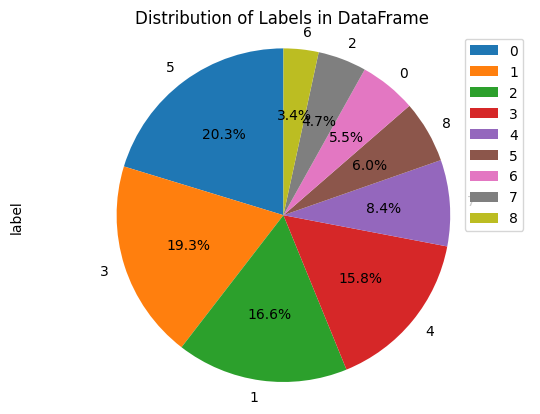

In [17]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [18]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


# Step 4 : Loading and resizing of images

In [19]:
max_images_per_class = 2000

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\soham\AppData\Local\Temp\ipykernel_5024\2406897109.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [20]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

16

In [21]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((224,224)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

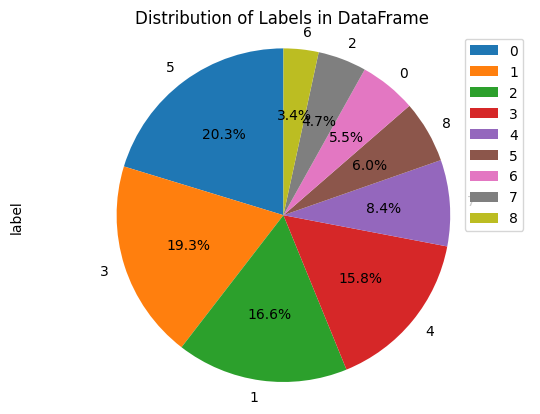

In [22]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [23]:
df.head()

,image_path,label,image
0,Skin cancer ISIC The International Skin Imagin...,0,"[[[135, 75, 83], [137, 77, 84], [141, 81, 86],..."
1,Skin cancer ISIC The International Skin Imagin...,0,"[[[114, 86, 88], [113, 85, 85], [109, 82, 78],..."
2,Skin cancer ISIC The International Skin Imagin...,0,"[[[159, 112, 105], [160, 112, 106], [167, 119,..."
3,Skin cancer ISIC The International Skin Imagin...,0,"[[[167, 86, 92], [173, 99, 102], [181, 109, 11..."
4,Skin cancer ISIC The International Skin Imagin...,0,"[[[206, 155, 156], [206, 154, 156], [208, 156,..."


> # Displaying the total number of images of each Class before Data Augmentation

In [24]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


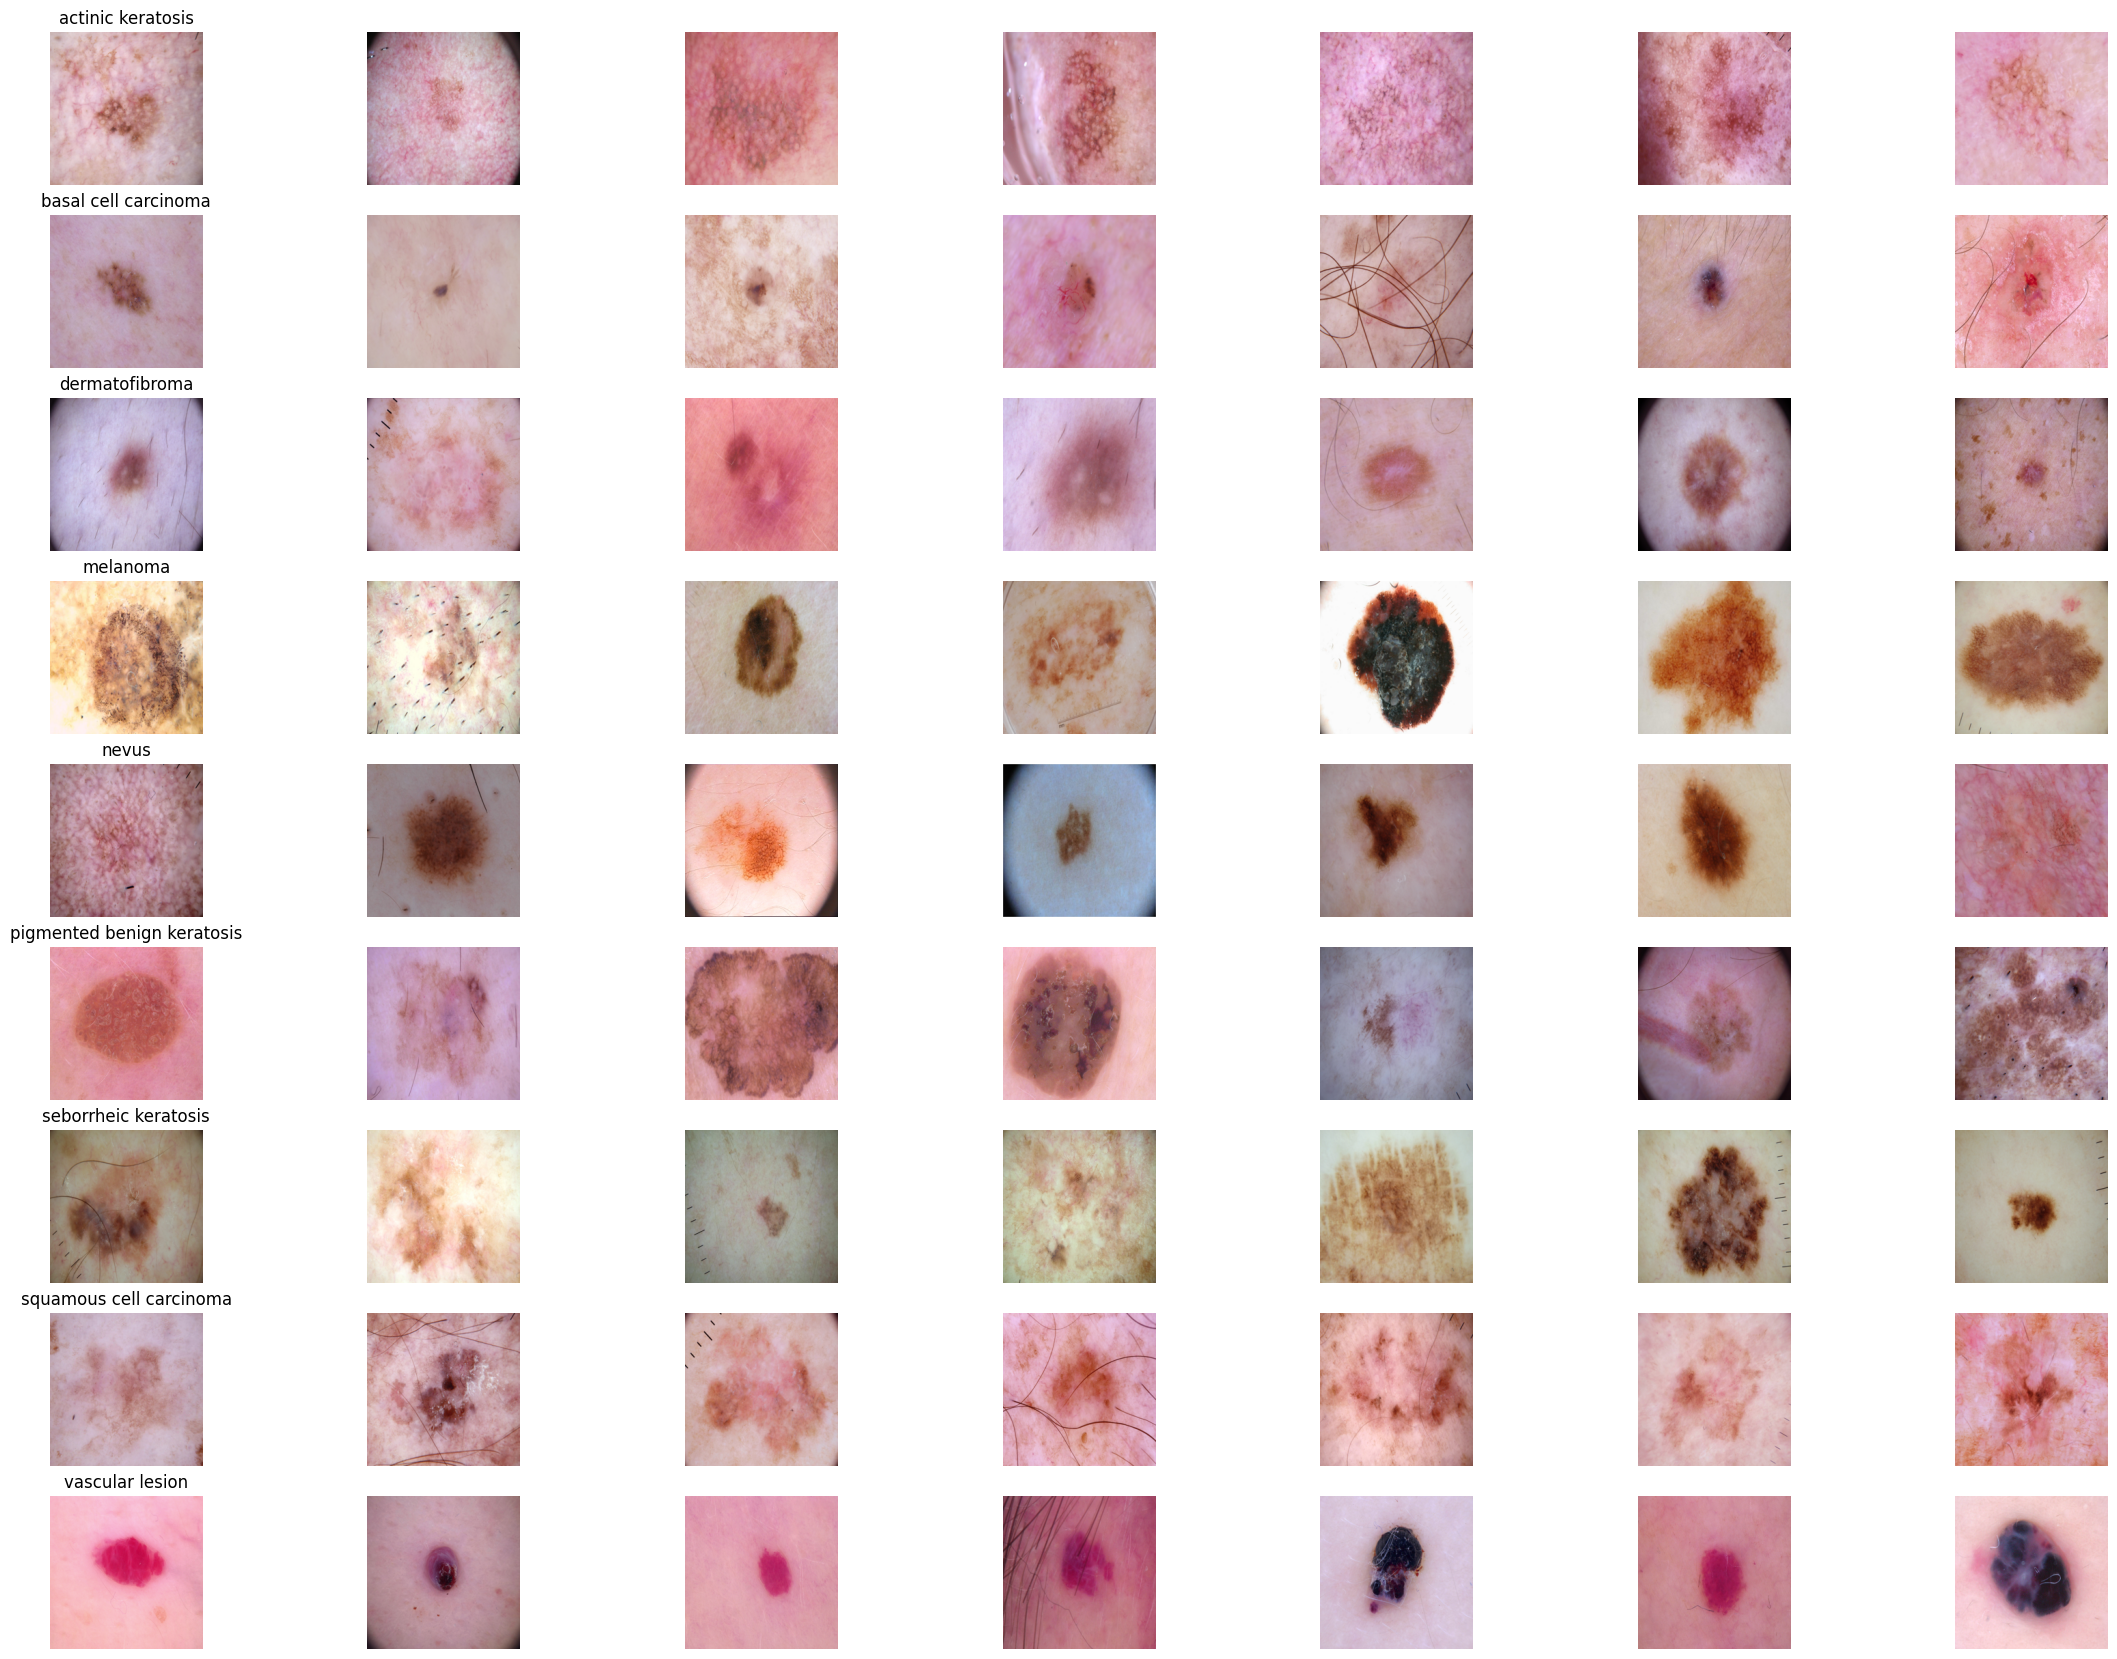

In [25]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [26]:
df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    2357
Name: image, dtype: int64

# Step 5 : Data Augmentation

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [28]:
output_folder = "augmented_images"  # Folder to save images

# Create an empty DataFrame to store augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Create the output directory
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed, replace=True)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        augmented_images_list = []  # List to store augmented images before adding to DataFrame
        
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented images list
            for i in range(augmented_images.n):
                augmented_image_array = next(augmented_images)[0].astype('uint8')  # Use next() instead of .next()
                
                # Save augmented image
                image_name = f"{class_label}_aug_{len(augmented_df)}.png"
                image_path = os.path.join(output_folder, image_name)
                Image.fromarray(augmented_image_array).save(image_path)
                
                augmented_images_list.append({'image_path': image_path, 'label': class_label, 'image': augmented_image_array})
        
        # Concatenate the list of augmented images into a DataFrame
        augmented_df = pd.concat([augmented_df, pd.DataFrame(augmented_images_list)], ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    for idx, row in df.loc[df['label'] == class_label].iterrows():
        # Save the original image
        original_image_array = row['image']
        image_name = f"{class_label}_orig_{idx}.png"
        image_path = os.path.join(output_folder, image_name)
        Image.fromarray(original_image_array).save(image_path)
        
        # Append to the augmented DataFrame
        augmented_df = pd.concat(
            [augmented_df, pd.DataFrame([{'image_path': image_path, 'label': row['label'], 'image': original_image_array}])],
            ignore_index=True
        )

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

# Shuffle and reset the index of the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Clear memory
del augmented_df

In [29]:
df.head()

,image_path,label,image
0,augmented_images\1_aug_2000.png,1,"[[[195, 185, 199], [196, 186, 202], [197, 187,..."
1,augmented_images\3_aug_6000.png,3,"[[[181, 174, 168], [182, 174, 170], [182, 174,..."
2,augmented_images\4_aug_8000.png,4,"[[[203, 173, 158], [204, 173, 157], [204, 171,..."
3,augmented_images\2_aug_4000.png,2,"[[[179, 129, 135], [181, 132, 141], [183, 135,..."
4,augmented_images\0_aug_0.png,0,"[[[201, 119, 131], [202, 120, 132], [202, 120,..."


> # Displaying the total number of images of each Class after Data Augmentation

In [30]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2000      
1               basal cell carcinoma           2000      
2               dermatofibroma                 2000      
3               melanoma                       2000      
4               nevus                          2000      
5               pigmented benign keratosis     2000      
6               seborrheic keratosis           2000      
7               squamous cell carcinoma        2000      
8               vascular lesion                2000      
------------------------------------------------------------
Total                                         18000     


# Step 6 : Train and Test split

In [31]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [32]:
features.head()

,image
0,"[[[195, 185, 199], [196, 186, 202], [197, 187,..."
1,"[[[181, 174, 168], [182, 174, 170], [182, 174,..."
2,"[[[203, 173, 158], [204, 173, 157], [204, 171,..."
3,"[[[179, 129, 135], [181, 132, 141], [183, 135,..."
4,"[[[201, 119, 131], [202, 120, 132], [202, 120,..."


In [33]:
target.head()

0    1
1    3
2    4
3    2
4    0
Name: label, dtype: object

In [34]:
print(target.shape,features.shape)

(18000,) (18000, 1)


In [35]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data

In [36]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


# Step 8 : Label Encoding

In [37]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split

In [38]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [39]:
# Reshape image in 3 dimensions (height = 224px, width = 224px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

In [40]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [41]:
input_shape = df['image'][0].shape
input_shape

(224, 224, 3)

In [42]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parameters
input_shape = (224, 224, 3)  # Image dimensions
batch_size = 16
num_classes = 9  # Number of classes
epochs = 15

In [43]:
# Convert labels to categorical (one-hot encoding)
df['label'] = df['label'].astype('category')
label_mapping = dict(enumerate(df['label'].cat.categories))
df['label'] = df['label'].cat.codes
df['label_onehot'] = df['label'].apply(lambda x: to_categorical(x, num_classes=num_classes))

In [44]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for training and validation
)

In [45]:
# Custom Data Generator
def custom_data_generator(df, batch_size, input_shape, datagen):
    while True:
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df.iloc[start:end]

            images = []
            labels = []

            for _, row in batch_df.iterrows():
                # Load and preprocess the image
                img = load_img(row['image_path'], target_size=input_shape[:2])
                img_array = img_to_array(img)
                images.append(img_array)

                # Get the label
                labels.append(row['label_onehot'])

            # Convert lists to arrays
            images = np.array(images)
            labels = np.array(labels)

            # Apply augmentation
            augmented = datagen.flow(images, labels, batch_size=batch_size, shuffle=False)
            for aug_images, aug_labels in augmented:
                yield aug_images, aug_labels
                break

# Create training and validation generators
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
val_df = df.drop(train_df.index)  # 20% for validation

train_generator = custom_data_generator(train_df, batch_size, input_shape, datagen)
val_generator = custom_data_generator(val_df, batch_size, input_shape, datagen)

# Calculate the steps per epoch
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

# Step 10 : Model Architecture

In [70]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2

# Input Layer
input_tensor = Input(shape=input_shape)

# MobileNetV2 Base Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Fine-tune last few layers of the base model
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers for fine-tuning
    layer.trainable = True

# Adding Global Average Pooling and Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling reduces the dimensions to 1D
x = BatchNormalization()(x)  # Normalize the activations
x = Dropout(0.4)(x)  # Dropout layer for regularization

# Adding Dense Layers with BatchNormalization and Dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Fully connected layer
x = BatchNormalization()(x)  # Normalize the dense layer outputs
x = Dropout(0.4)(x)  # Add dropout for further regularization

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Additional Dense layer
x = BatchNormalization()(x)  # Normalize again
x = Dropout(0.3)(x)  # Slightly lower dropout here

# Output Layer
output_tensor = Dense(num_classes, activation='softmax')(x)

# Create the Model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Step 11 : Setting Optimizer

In [71]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path to save the best model
best_model_path = "mobilenetv2_final.keras"

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath=best_model_path,          # Path where the model will be saved
    monitor='val_accuracy',            # Metric to monitor
    verbose=1,                         # Verbosity mode
    save_best_only=True,               # Save only when the monitored metric improves
    mode='max',                        # Mode ('max' for accuracy, 'min' for loss)
    save_weights_only=False            # Save the full model (architecture + weights)
)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[learning_rate_reduction, checkpoint]  # Include the checkpoint callback
)

Epoch 1/15
900/900 [==============================] - ETA: 0s - loss: 9.4604 - accuracy: 0.8858
Epoch 1: val_accuracy improved from -inf to 0.92639, saving model to mobilenetv2_final.keras
900/900 [==============================] - 204s 223ms/step - loss: 9.4604 - accuracy: 0.8858 - val_loss: 7.7695 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 2/15
900/900 [==============================] - ETA: 0s - loss: 6.6135 - accuracy: 0.9190
Epoch 2: val_accuracy improved from 0.92639 to 0.93167, saving model to mobilenetv2_final.keras
900/900 [==============================] - 191s 212ms/step - loss: 6.6135 - accuracy: 0.9190 - val_loss: 5.4781 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 3/15
900/900 [==============================] - ETA: 0s - loss: 4.6733 - accuracy: 0.9274
Epoch 3: val_accuracy did not improve from 0.93167
900/900 [==============================] - 187s 208ms/step - loss: 4.6733 - accuracy: 0.9274 - val_loss: 3.8929 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 4/15
900/900 [========

In [59]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D,
    BatchNormalization, Add, LeakyReLU
)
from tensorflow.keras.regularizers import l2

# Input Layer
input_tensor = Input(shape=input_shape)

# MobileNetV2 Base Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [64]:
# Fine-tune the last 30 layers
for layer in base_model.layers[:-30]:  # Freeze all layers except last 30
    layer.trainable = False

# Base model output
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling reduces dimensions

# First Dense Block
dense1 = Dense(512, kernel_regularizer=l2(0.01))(x)
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU(alpha=0.1)(dense1)
dense1 = Dropout(0.5)(dense1)

# Second Dense Block
dense2 = Dense(256, kernel_regularizer=l2(0.01))(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = LeakyReLU(alpha=0.1)(dense2)
dense2 = Dropout(0.4)(dense2)

# Skip Connection (Match Sizes)
shortcut = Dense(256, kernel_regularizer=l2(0.01))(dense1)  # Projection layer
shortcut = BatchNormalization()(shortcut)

# Add skip connection
skip = Add()([shortcut, dense2])  # Combines features
skip = Dropout(0.3)(skip)

# Final Dense Block
dense3 = Dense(128, kernel_regularizer=l2(0.01))(skip)
dense3 = BatchNormalization()(dense3)
dense3 = LeakyReLU(alpha=0.1)(dense3)
dense3 = Dropout(0.3)(dense3)

# Output Layer
output_tensor = Dense(num_classes, activation='softmax')(dense3)

# Create Model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile Model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [65]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)

# Save the best model
checkpoint = ModelCheckpoint(
    filepath="improved_mobilenetv2.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [66]:
# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[lr_reduction, checkpoint]
)

Epoch 1/15
900/900 [==============================] - ETA: 0s - loss: 4.6591 - accuracy: 0.8920
Epoch 1: val_accuracy improved from -inf to 0.88528, saving model to improved_mobilenetv2.keras
900/900 [==============================] - 191s 208ms/step - loss: 4.6591 - accuracy: 0.8920 - val_loss: 0.8365 - val_accuracy: 0.8853 - lr: 5.0000e-04
Epoch 2/15
900/900 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.9065
Epoch 2: val_accuracy improved from 0.88528 to 0.91806, saving model to improved_mobilenetv2.keras
900/900 [==============================] - 201s 224ms/step - loss: 0.6422 - accuracy: 0.9065 - val_loss: 0.5074 - val_accuracy: 0.9181 - lr: 5.0000e-04
Epoch 3/15
900/900 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.9100
Epoch 3: val_accuracy improved from 0.91806 to 0.93056, saving model to improved_mobilenetv2.keras
900/900 [==============================] - 198s 220ms/step - loss: 0.5542 - accuracy: 0.9100 - val_loss: 0.4740 - 

# Step 13 : Model Evaluation

In [46]:
from tensorflow.keras.models import load_model

# Load the best model
mobilenetv2 = load_model('mobilenetv2_final.keras')


In [52]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the best saved model
# best_model = load_model("best_model.h5")

# Define the target image size (must match the input shape of the model)
target_size = (224, 224)  # Example for MobileNetV2 input size

# Path to the single image
image_path = r'C:\Users\soham\Desktop\New folder (2)\Skin cancer ISIC The International Skin Imaging Collaboration\Test\nevus\ISIC_0000017.jpg'

# Preprocess the image
def preprocess_image(image_path, target_size):
    # Load the image with the target size
    image = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Scale the pixel values to the range [0, 1] (if required by the model)
    image_array = image_array / 255.0
    # Add a batch dimension (1, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Preprocess the single image
processed_image = preprocess_image(image_path, target_size)

# Predict the class
predictions = mobilenetv2.predict(processed_image)

# Decode the predictions
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability
class_names = {0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}
confidence = np.max(predictions)  # Get the confidence of the prediction
print(predictions)
print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")


1/1 [==============================] - 0s 21ms/step
[[2.9307220e-04 1.5023723e-05 9.5771982e-05 1.3829494e-01 8.4893966e-01
  6.8191835e-03 5.4410873e-03 7.4861797e-05 2.6430545e-05]]
Predicted Class: nevus, Confidence: 0.85


Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.97      0.96      0.96       381
      basal cell carcinoma       0.94      0.96      0.95       391
            dermatofibroma       0.99      0.96      0.98       391
                  melanoma       0.93      0.89      0.91       415
                     nevus       0.91      0.93      0.92       378
pigmented benign keratosis       0.87      0.94      0.91       398
      seborrheic keratosis       1.00      0.95      0.98       420
   squamous cell carcinoma       0.94      0.95      0.94       413
           vascular lesion       1.00      0.99      1.00       413

                  accuracy                           0.95      3600
                 macro avg       0.95      0.95      0.95      3600
              weighted avg       0.95      0.95      0.95      3600



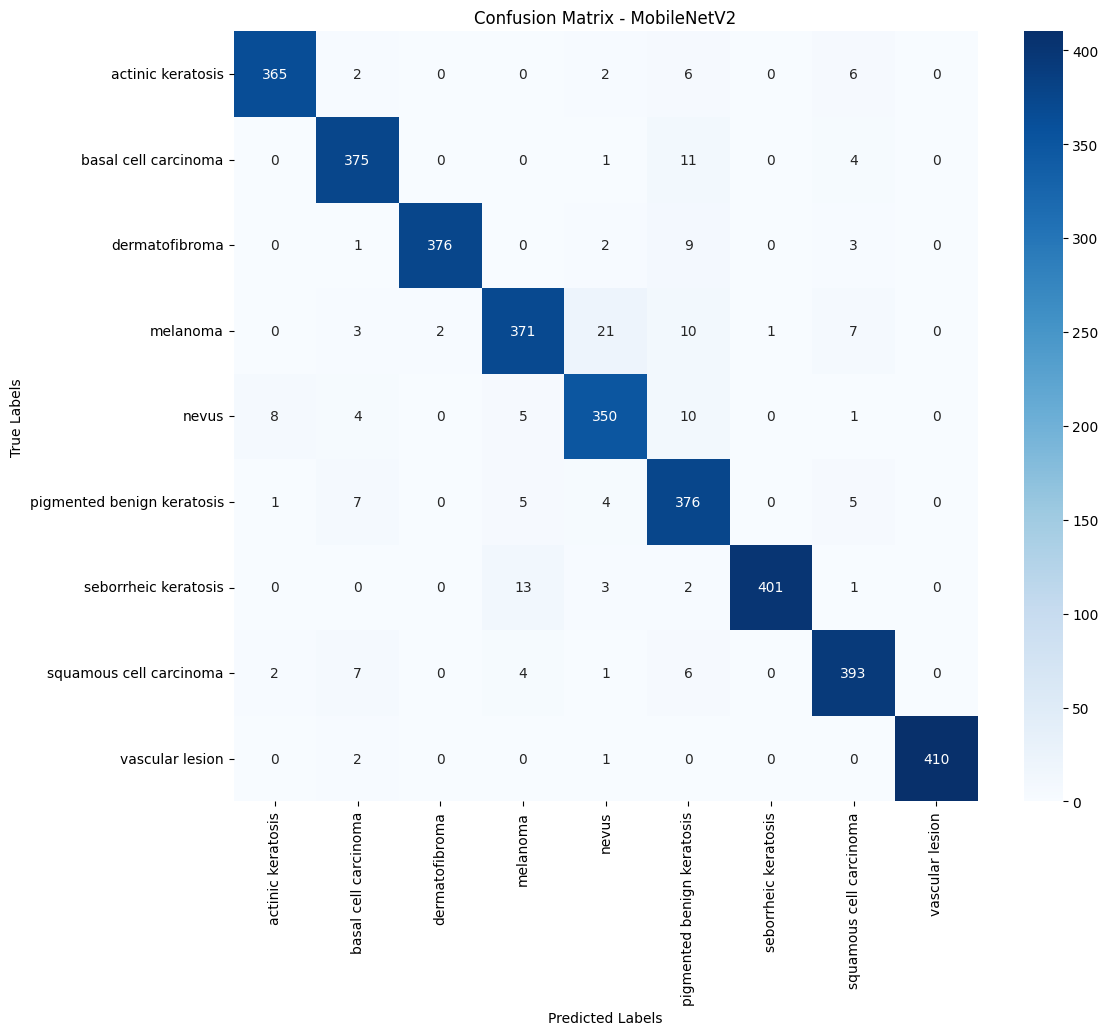

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names = {0: 'actinic keratosis',
               1: 'basal cell carcinoma',
               2: 'dermatofibroma',
               3: 'melanoma',
               4: 'nevus',
               5: 'pigmented benign keratosis',
               6: 'seborrheic keratosis',
               7: 'squamous cell carcinoma',
               8: 'vascular lesion'}

# Collect true and predicted labels
y_true = []
y_pred = []

for step in range(val_steps):
    # Get a batch of data
    images, labels = next(val_generator)

    # Predict the probabilities for the batch
    y_pred_probs = mobilenetv2.predict(images, verbose=0)

    # Append true labels and predicted labels
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    y_pred.extend(np.argmax(y_pred_probs, axis=1))  # Convert probabilities to class indices

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()


# Step 14 : Saving the model

In [81]:
model.save("mobilenetv2_final.keras")

# Making EfficientNetB0 model

In [82]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Input Layer
input_tensor = Input(shape=input_shape)

# EfficientNet Base Model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Adding Global Average Pooling and Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling reduces dimensions to 1D
x = BatchNormalization()(x)  # Normalize activations for stability
x = Dropout(0.4)(x)  # Regularization with Dropout

# Additional Dense Layers with BatchNormalization and Dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer
output_tensor = Dense(num_classes, activation='softmax')(x)

# Create the Model
efficientnet_model = Model(inputs=input_tensor, outputs=output_tensor)

16705208/16705208 [==============================] - 3s 0us/step


Setting optimiser

In [83]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path to save the best model
best_model_path = "efficientnetb0_final.keras"

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath=best_model_path,          # Path where the model will be saved
    monitor='val_accuracy',            # Metric to monitor
    verbose=1,                         # Verbosity mode
    save_best_only=True,               # Save only when the monitored metric improves
    mode='max',                        # Mode ('max' for accuracy, 'min' for loss)
    save_weights_only=False            # Save the full model (architecture + weights)
)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[learning_rate_reduction, checkpoint]  # Include the checkpoint callback
)

Epoch 1/15
900/900 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.9558
Epoch 1: val_accuracy improved from -inf to 0.94139, saving model to efficientnetb0_final.keras
900/900 [==============================] - 185s 202ms/step - loss: 0.4519 - accuracy: 0.9558 - val_loss: 0.4659 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 2/15
900/900 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9569
Epoch 2: val_accuracy improved from 0.94139 to 0.94750, saving model to efficientnetb0_final.keras
900/900 [==============================] - 183s 203ms/step - loss: 0.3858 - accuracy: 0.9569 - val_loss: 0.3970 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 3/15
900/900 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.9587
Epoch 3: val_accuracy did not improve from 0.94750
900/900 [==============================] - 184s 204ms/step - loss: 0.3331 - accuracy: 0.9587 - val_loss: 0.3606 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 4/15
900/900 [==

# Model evaluation

In [85]:
from tensorflow.keras.models import load_model

# Load the best model
efficientnetb0 = load_model('efficientnetb0_final.keras')

In [86]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the best saved model
# best_model = load_model("best_model.h5")

# Define the target image size (must match the input shape of the model)
target_size = (224, 224)  # Example for MobileNetV2 input size

# Path to the single image
image_path = r"C:\Users\soham\Desktop\New folder (2)\Skin cancer ISIC The International Skin Imaging Collaboration\Test\basal cell carcinoma\ISIC_0024360.jpg"

# Preprocess the image
def preprocess_image(image_path, target_size):
    # Load the image with the target size
    image = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Scale the pixel values to the range [0, 1] (if required by the model)
    image_array = image_array / 255.0
    # Add a batch dimension (1, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Preprocess the single image
processed_image = preprocess_image(image_path, target_size)

# Predict the class
predictions = efficientnetb0.predict(processed_image)

# Decode the predictions
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability
class_names = {0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}
confidence = np.max(predictions)  # Get the confidence of the prediction
print(predictions)
print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")


1/1 [==============================] - 1s 726ms/step
[[2.9464616e-05 9.9843830e-01 1.9047559e-06 7.5605171e-06 1.1440667e-04
  1.1421078e-03 1.2672265e-06 1.1024370e-05 2.5389710e-04]]
Predicted Class: basal cell carcinoma, Confidence: 1.00


Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.96      0.95      0.96       381
      basal cell carcinoma       0.96      0.96      0.96       391
            dermatofibroma       0.98      0.98      0.98       391
                  melanoma       0.91      0.90      0.90       415
                     nevus       0.90      0.94      0.92       378
pigmented benign keratosis       0.91      0.93      0.92       398
      seborrheic keratosis       0.99      0.95      0.97       420
   squamous cell carcinoma       0.96      0.94      0.95       413
           vascular lesion       1.00      0.99      0.99       413

                  accuracy                           0.95      3600
                 macro avg       0.95      0.95      0.95      3600
              weighted avg       0.95      0.95      0.95      3600



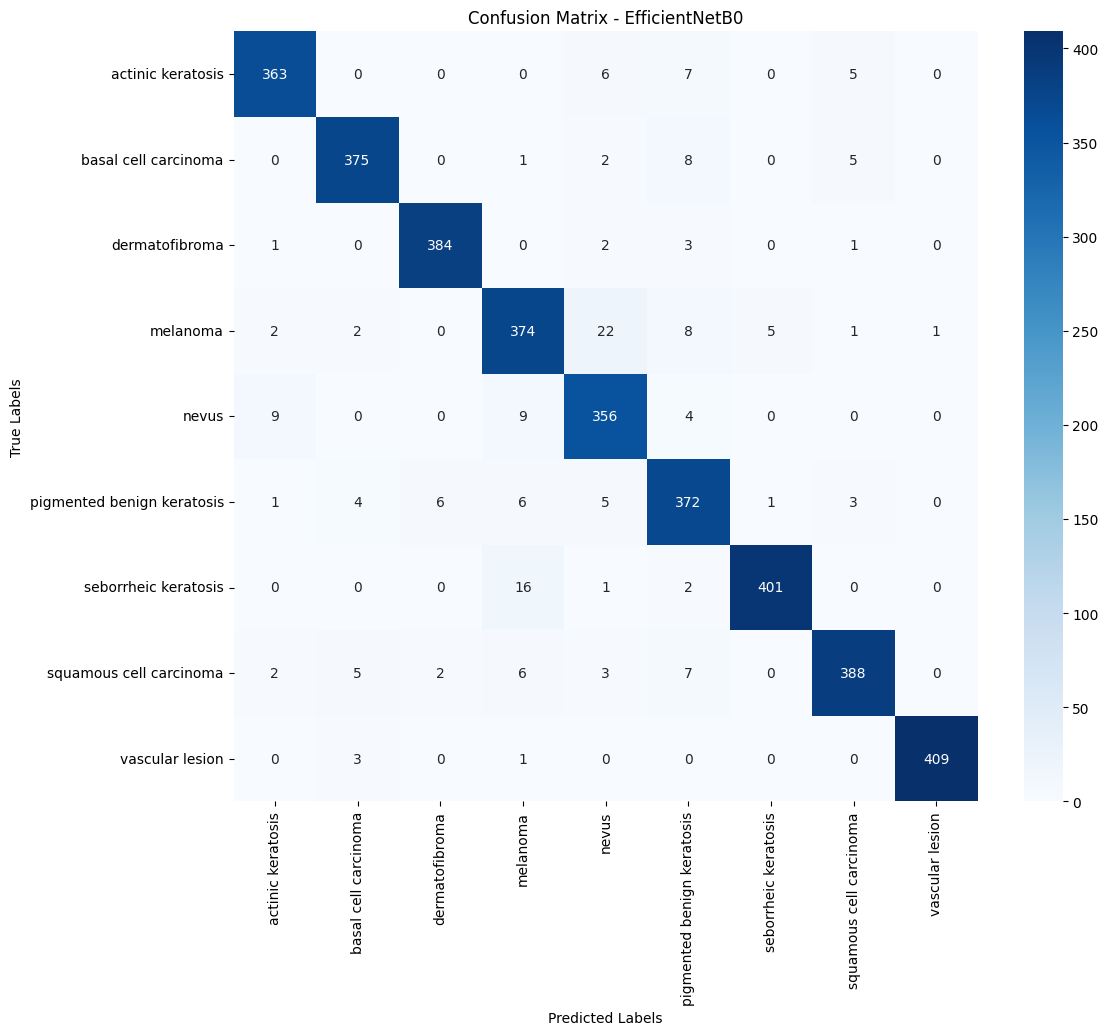

In [87]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names = {0: 'actinic keratosis',
               1: 'basal cell carcinoma',
               2: 'dermatofibroma',
               3: 'melanoma',
               4: 'nevus',
               5: 'pigmented benign keratosis',
               6: 'seborrheic keratosis',
               7: 'squamous cell carcinoma',
               8: 'vascular lesion'}

# Collect true and predicted labels
y_true = []
y_pred = []

for step in range(val_steps):
    # Get a batch of data
    images, labels = next(val_generator)

    # Predict the probabilities for the batch
    y_pred_probs = efficientnetb0.predict(images, verbose=0)

    # Append true labels and predicted labels
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    y_pred.extend(np.argmax(y_pred_probs, axis=1))  # Convert probabilities to class indices

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()


# Now we make DenseNet201 Model

In [88]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Input Layer
input_tensor = Input(shape=input_shape)

# DenseNet201 Base Model
base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Adding Global Average Pooling and Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling reduces dimensions to 1D
x = BatchNormalization()(x)  # Normalize activations for stability
x = Dropout(0.4)(x)  # Regularization with Dropout

# Additional Dense Layers with BatchNormalization and Dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer
output_tensor = Dense(num_classes, activation='softmax')(x)

# Create the Model
densenet_model = Model(inputs=input_tensor, outputs=output_tensor)


74836368/74836368 [==============================] - 6s 0us/step


In [89]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [90]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path to save the best model
best_model_path = "densenet201.keras"

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath=best_model_path,          # Path where the model will be saved
    monitor='val_accuracy',            # Metric to monitor
    verbose=1,                         # Verbosity mode
    save_best_only=True,               # Save only when the monitored metric improves
    mode='max',                        # Mode ('max' for accuracy, 'min' for loss)
    save_weights_only=False            # Save the full model (architecture + weights)
)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[learning_rate_reduction, checkpoint]  # Include the checkpoint callback
)

Epoch 1/15
900/900 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9722
Epoch 1: val_accuracy improved from -inf to 0.94611, saving model to densenet201.keras
900/900 [==============================] - 201s 220ms/step - loss: 0.1511 - accuracy: 0.9722 - val_loss: 0.2691 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 2/15
900/900 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9722
Epoch 2: val_accuracy did not improve from 0.94611
900/900 [==============================] - 187s 208ms/step - loss: 0.1582 - accuracy: 0.9722 - val_loss: 0.2914 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 3/15
900/900 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9725
Epoch 3: val_accuracy improved from 0.94611 to 0.94806, saving model to densenet201.keras
900/900 [==============================] - 180s 200ms/step - loss: 0.1601 - accuracy: 0.9725 - val_loss: 0.2812 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 4/15
900/900 [====================

In [91]:
from tensorflow.keras.models import load_model

# Load the best model
densenet201 = load_model('densenet201.keras')

In [92]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the best saved model
# best_model = load_model("best_model.h5")

# Define the target image size (must match the input shape of the model)
target_size = (224, 224)  # Example for MobileNetV2 input size

# Path to the single image
image_path = r"C:\Users\soham\Desktop\New folder (2)\Skin cancer ISIC The International Skin Imaging Collaboration\Test\basal cell carcinoma\ISIC_0024360.jpg"

# Preprocess the image
def preprocess_image(image_path, target_size):
    # Load the image with the target size
    image = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Scale the pixel values to the range [0, 1] (if required by the model)
    image_array = image_array / 255.0
    # Add a batch dimension (1, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Preprocess the single image
processed_image = preprocess_image(image_path, target_size)

# Predict the class
predictions = densenet201.predict(processed_image)

# Decode the predictions
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability
class_names = {0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}
confidence = np.max(predictions)  # Get the confidence of the prediction
print(predictions)
print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")


1/1 [==============================] - 1s 786ms/step
[[6.5263503e-06 9.9940538e-01 3.2804613e-07 6.1208793e-06 6.2896477e-05
  5.1376771e-04 3.8833537e-08 3.6447364e-07 4.5027718e-06]]
Predicted Class: basal cell carcinoma, Confidence: 1.00


Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.96      0.94      0.95       381
      basal cell carcinoma       0.98      0.95      0.97       391
            dermatofibroma       1.00      0.98      0.99       391
                  melanoma       0.91      0.91      0.91       415
                     nevus       0.91      0.93      0.92       378
pigmented benign keratosis       0.93      0.95      0.94       398
      seborrheic keratosis       0.97      0.95      0.96       420
   squamous cell carcinoma       0.93      0.96      0.95       413
           vascular lesion       0.99      1.00      0.99       413

                  accuracy                           0.95      3600
                 macro avg       0.95      0.95      0.95      3600
              weighted avg       0.95      0.95      0.95      3600



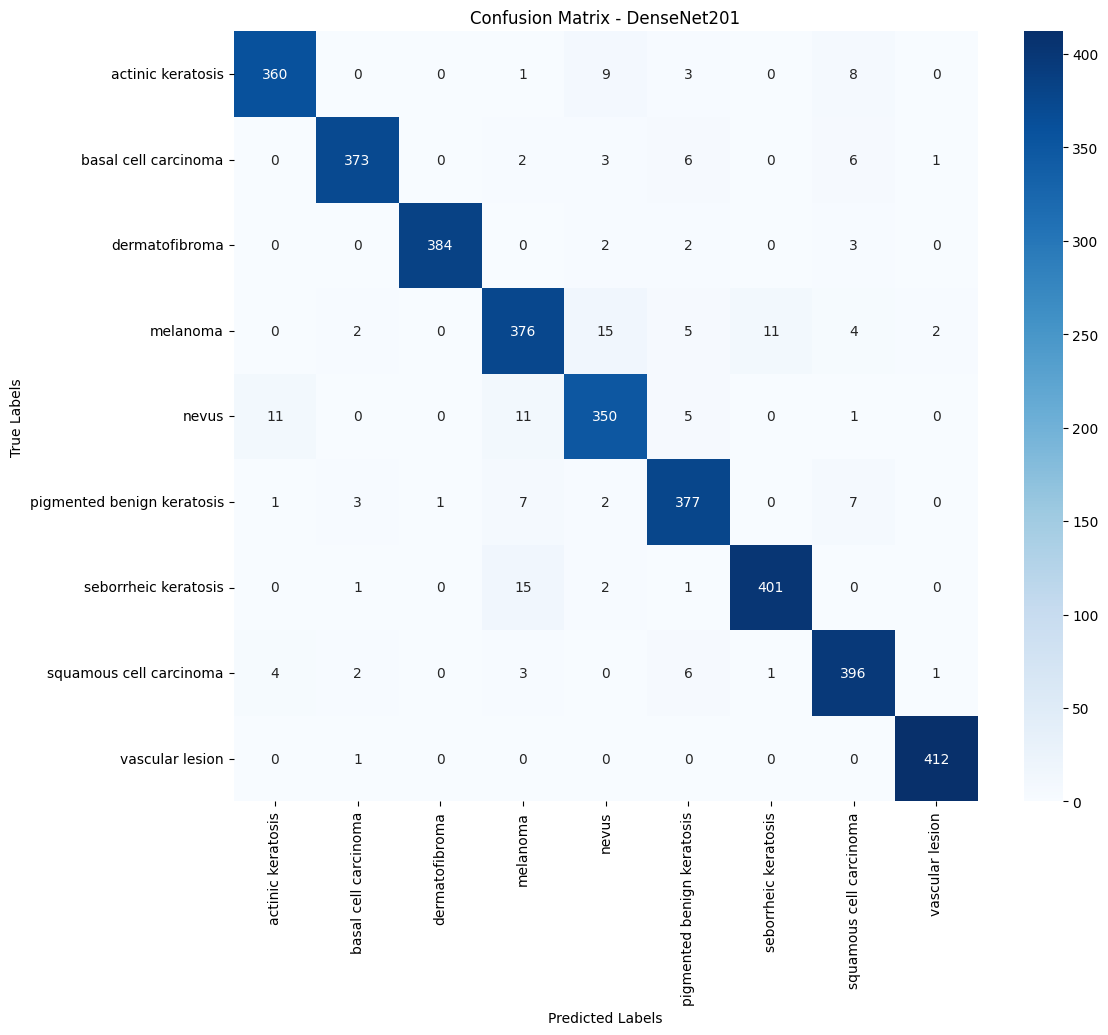

In [93]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names = {0: 'actinic keratosis',
               1: 'basal cell carcinoma',
               2: 'dermatofibroma',
               3: 'melanoma',
               4: 'nevus',
               5: 'pigmented benign keratosis',
               6: 'seborrheic keratosis',
               7: 'squamous cell carcinoma',
               8: 'vascular lesion'}

# Collect true and predicted labels
y_true = []
y_pred = []

for step in range(val_steps):
    # Get a batch of data
    images, labels = next(val_generator)

    # Predict the probabilities for the batch
    y_pred_probs = densenet201.predict(images, verbose=0)

    # Append true labels and predicted labels
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    y_pred.extend(np.argmax(y_pred_probs, axis=1))  # Convert probabilities to class indices

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - DenseNet201')
plt.show()


# Now we use ensemble

In [9]:
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import matplotlib.pyplot as plt

# Create directory for saving models
save_dir = os.path.join(os.getcwd(), "save_models")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load pre-trained models
mobilenetv2_base = load_model('mobilenetv2_final.keras', compile=False)
efficientnetb0_base = load_model('efficientnetb0_final.keras', compile=False)
densenet201_base = load_model('densenet201.keras', compile=False)

# Wrap models with unique names
mobilenetv2 = Model(inputs=mobilenetv2_base.input, outputs=mobilenetv2_base.output, name="mobilenetv2")
efficientnetb0 = Model(inputs=efficientnetb0_base.input, outputs=efficientnetb0_base.output, name="efficientnetb0")
densenet201 = Model(inputs=densenet201_base.input, outputs=densenet201_base.output, name="densenet201")

# Stacking architecture
stacking_input = Input(shape=(224, 224, 3), name="stacking_input")
mobilenetv2_pred = mobilenetv2(stacking_input)
efficientnetb0_pred = efficientnetb0(stacking_input)
densenet201_pred = densenet201(stacking_input)

# Combine predictions
combined = Concatenate(name="combined")([mobilenetv2_pred, efficientnetb0_pred, densenet201_pred])

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Average, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Meta-Model Architecture
x = Dense(256, name="dense_256")(combined)
x = BatchNormalization(axis=-1, name="bn_256")(x)
x = LeakyReLU(alpha=0.2, name="activation_256")(x)
x = Dropout(0.2, name="dropout_256")(x)

x = Dense(128, name="dense_128")(x)
x = BatchNormalization(axis=-1, name="bn_128")(x)
x = LeakyReLU(alpha=0.2, name="activation_128")(x)
x = Dropout(0.2, name="dropout_128")(x)

# Output Layer
output = Dense(9, activation='softmax', name="output")(x)


In [11]:
# Define and Compile the Stacked Model
stacked_model = Model(inputs=stacking_input, outputs=output, name="stacked_model")
stacked_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=[CategoricalAccuracy(name="accuracy")]
)

In [12]:
filepath = "cnn_weights.{epoch:02d}-{val_loss:.4f}--0fold.tf"
checkpoint_cb = ModelCheckpoint(
    os.path.join(save_dir, filepath),
    monitor="val_loss",
    verbose=1,
    save_best_only=False,  # Save all models for each epoch
    mode='min'
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

Epoch 1/15
900/900 [==============================] - ETA: 0s - loss: 1.3941 - accuracy: 0.8426
Epoch 1: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.01-2.8915--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.01-2.8915--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.01-2.8915--0fold.tf\assets


900/900 [==============================] - 452s 481ms/step - loss: 1.3941 - accuracy: 0.8426 - val_loss: 2.8915 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 2/15
900/900 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.8847
Epoch 2: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.02-1.2495--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.02-1.2495--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.02-1.2495--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.0540 - accuracy: 0.8847 - val_loss: 1.2495 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 3/15
900/900 [==============================] - ETA: 0s - loss: 1.2334 - accuracy: 0.8888
Epoch 3: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.03-1.4920--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.03-1.4920--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.03-1.4920--0fold.tf\assets


900/900 [==============================] - 431s 479ms/step - loss: 1.2334 - accuracy: 0.8888 - val_loss: 1.4920 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 4/15
900/900 [==============================] - ETA: 0s - loss: 1.1275 - accuracy: 0.8920
Epoch 4: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.04-2.1629--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.04-2.1629--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.04-2.1629--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.1275 - accuracy: 0.8920 - val_loss: 2.1629 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 5/15
900/900 [==============================] - ETA: 0s - loss: 1.2120 - accuracy: 0.8944
Epoch 5: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.05-0.9801--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.05-0.9801--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.05-0.9801--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.2120 - accuracy: 0.8944 - val_loss: 0.9801 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 6/15
900/900 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.9001
Epoch 6: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.06-0.9902--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.06-0.9902--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.06-0.9902--0fold.tf\assets


900/900 [==============================] - 433s 481ms/step - loss: 1.0588 - accuracy: 0.9001 - val_loss: 0.9902 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 7/15
900/900 [==============================] - ETA: 0s - loss: 1.1883 - accuracy: 0.9067
Epoch 7: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.07-1.0874--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.07-1.0874--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.07-1.0874--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.1883 - accuracy: 0.9067 - val_loss: 1.0874 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 8/15
900/900 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.9060
Epoch 8: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.08-0.9702--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.08-0.9702--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.08-0.9702--0fold.tf\assets


900/900 [==============================] - 433s 481ms/step - loss: 1.1587 - accuracy: 0.9060 - val_loss: 0.9702 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 9/15
900/900 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.9035
Epoch 9: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.09-0.9196--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.09-0.9196--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.09-0.9196--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.1944 - accuracy: 0.9035 - val_loss: 0.9196 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 10/15
900/900 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.9081
Epoch 10: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.10-0.9596--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.10-0.9596--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.10-0.9596--0fold.tf\assets


900/900 [==============================] - 432s 481ms/step - loss: 1.1287 - accuracy: 0.9081 - val_loss: 0.9596 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 11/15
900/900 [==============================] - ETA: 0s - loss: 1.0808 - accuracy: 0.9108
Epoch 11: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.11-0.8020--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.11-0.8020--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.11-0.8020--0fold.tf\assets


900/900 [==============================] - 432s 480ms/step - loss: 1.0808 - accuracy: 0.9108 - val_loss: 0.8020 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 12/15
900/900 [==============================] - ETA: 0s - loss: 1.2858 - accuracy: 0.9081
Epoch 12: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.12-1.2029--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.12-1.2029--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.12-1.2029--0fold.tf\assets


900/900 [==============================] - 433s 481ms/step - loss: 1.2858 - accuracy: 0.9081 - val_loss: 1.2029 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 13/15
900/900 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.9151
Epoch 13: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.13-1.1987--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.13-1.1987--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.13-1.1987--0fold.tf\assets


900/900 [==============================] - 432s 481ms/step - loss: 1.0097 - accuracy: 0.9151 - val_loss: 1.1987 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 14/15
900/900 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.9152
Epoch 14: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.14-0.8116--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.14-0.8116--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.14-0.8116--0fold.tf\assets


900/900 [==============================] - 433s 481ms/step - loss: 0.9883 - accuracy: 0.9152 - val_loss: 0.8116 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 15/15
900/900 [==============================] - ETA: 0s - loss: 1.2564 - accuracy: 0.9140
Epoch 15: saving model to c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.15-1.6064--0fold.tf


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.15-1.6064--0fold.tf\assets


INFO:tensorflow:Assets written to: c:\Users\soham\Desktop\New folder (2)\save_models\cnn_weights.15-1.6064--0fold.tf\assets


900/900 [==============================] - 433s 481ms/step - loss: 1.2564 - accuracy: 0.9140 - val_loss: 1.6064 - val_accuracy: 0.8192 - lr: 0.0010


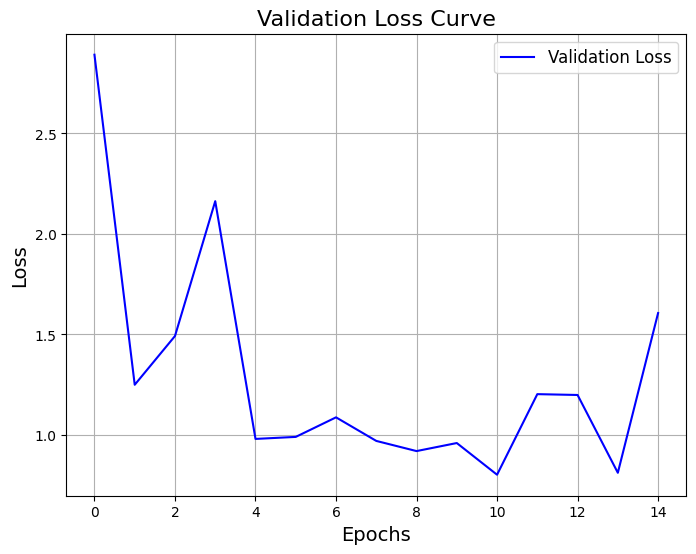

In [47]:
# Train the Model
history = stacked_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[learning_rate_reduction, checkpoint_cb]
)

# Plot Validation Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Validation Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()